In [14]:
import numpy as np
import pandas as pd
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt

ensayo3_excel = r"C:\Users\rayom\OneDrive\Documentos\GitHub\Neurociencias-2026-1\S03_datasets\eeg-motor-movementimagery_Ensayo_03.xlsx"
ensayo4_excel = r"C:\Users\rayom\OneDrive\Documentos\GitHub\Neurociencias-2026-1\S03_datasets\eeg-motor-movementimagery_Ensayo_04.xlsx"
ensayo5_excel =r"C:\Users\rayom\OneDrive\Documentos\GitHub\Neurociencias-2026-1\S03_datasets\eeg-motor-movementimagery_Ensayo_05.xlsx"
ensayo6_excel =r"C:\Users\rayom\OneDrive\Documentos\GitHub\Neurociencias-2026-1\S03_datasets\eeg-motor-movementimagery_Ensayo_06.xlsx"
coordenadas_csv = r"C:\Users\rayom\OneDrive\Documentos\GitHub\Neurociencias-2026-1\S03_datasets\MI_coordinates.csv"

# Leemos archivo xlsx de ensayo con 109 sujetos
ensayo3_dict = pd.read_excel(ensayo3_excel, sheet_name=None, index_col=0)
ensayo4_dict = pd.read_excel(ensayo4_excel, sheet_name=None, index_col=0)
ensayo5_dict = pd.read_excel(ensayo5_excel, sheet_name=None, index_col=0)
ensayo6_dict = pd.read_excel(ensayo6_excel, sheet_name=None, index_col=0)


In [44]:
def lista_dfs(ensayo3_dict):
    ensayos_dfs_ = []
    for sujeto in ensayo3_dict.keys():
        ensayos_dfs_.append(ensayo3_dict[sujeto])
    return ensayos_dfs_

lista_dfs(ensayo3_dict)

lista_e3 = lista_dfs(ensayo3_dict)

In [56]:

# Filtrado de matrices
def capsula(lista_dfs_, th=0.4, porcentaje=0.6):
    # Conjuntamos las matrices
    stack = np.stack([df.values for df in lista_dfs_])
    # Aplicamos filtro a cada matriz
    above = stack > th

    N = len(lista_dfs_) # = 109
    count_above = above.sum(axis=0) # Contando cuantos valores superan el umbral en celda

    min_requerido = int(np.ceil(porcentaje*N)) # 0.6*109 = 65.4
    # con esto bastara con quedarnos con las celdas de 'above' que cumplan con min_requerido
    # para así tener el número de sujetos que superan el umbral
    result_bool = count_above >= min_requerido

    result_df = pd.DataFrame(result_bool,
                             index=lista_dfs_[0].index,
                             columns=lista_dfs_[0].columns).astype(int)
    return result_df

MatrizE3= capsula(lista_e3, th=0.4, porcentaje=0.6)

In [63]:
G = nx.from_pandas_adjacency(MatrizE3)

def metricas_grafo(G):
    # Métricas:
    #Clusterin promedio
    clust_coeff = nx.average_clustering(G)
    # Longitud de camino promedio (camino más corto)
    try:
        path_length = nx.average_shortest_path_length(G)
    except nx.NetworkXError:
        path_length = np.nan # red no conexa
    # Coeficiente de mundo pequeño
    # Comparar con grafo aleatorio de igual N, K
    G_rand = nx.gnm_random_graph(n=G.number_of_nodes(), m=G.number_of_edges())
    clust_rand = nx.average_clustering(G_rand)
    path_rand = nx.average_shortest_path_length(G_rand)
    small_world_sigma = (clust_coeff / clust_rand) / (path_length / path_rand)
    # Modularidad
    from networkx.algorithms import community
    communities = community.greedy_modularity_communities(G)
    modularity = community.modularity(G, communities)
    # Hubs
    degree_dict = dict(G.degree())
    betwenness = nx.betweenness_centrality(G)
    betwenness = sorted(betwenness.items(), key=lambda x: x[1], reverse=True)
    # Eficiencia global y local
    global_eff = nx.global_efficiency(G)
    local_eff = nx.local_efficiency(G)

    return (clust_coeff, path_length, small_world_sigma, communities,
            modularity, betwenness, global_eff, local_eff, degree_dict)

MetricasE3 = metricas_grafo(G)
# Extraer las métricas
(_, _, _, _, _, betweenness_sorted, _, _, degree_dict) = MetricasE3

import pandas as pd

df_metricas_nodos = pd.DataFrame({
    "Nodo": degree_dict.keys(),
    "Degree": degree_dict.values(),
    "Betweenness": [b for _, b in betweenness_sorted]
})

df_metricas_nodos = df_metricas_nodos.sort_values("Degree", ascending=False)
df_metricas_nodos


,Nodo,Degree,Betweenness
16,Cp1.,35,0.023872
15,Cp3.,32,0.025772
17,Cpz.,32,0.023829
51,P2..,32,0.002335
11,C2..,31,0.029637
...,...,...,...
28,Af8.,2,0.014811
42,T9..,2,0.006985
41,T8..,1,0.007964
43,T10.,0,0.006658


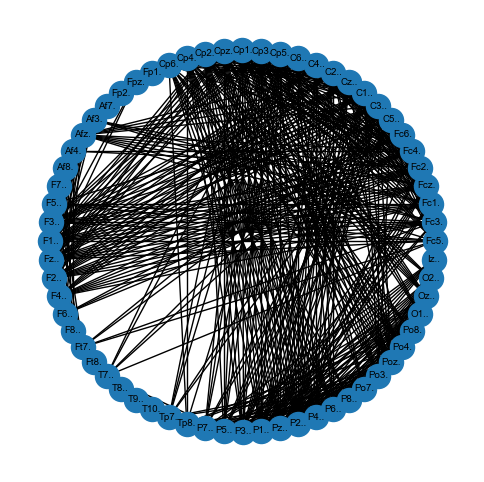

In [61]:
fig, ax = plt.subplots(figsize=(6, 6))
# Grafo 2D
def grafo2D(MatrizE3, ax):
    ensayo_grafo = nx.from_pandas_adjacency(MatrizE3)
    nx.draw_circular(ensayo_grafo, with_labels=True, font_size=7, ax=ax)

    return ensayo_grafo

Grafo2D_E3=grafo2D(MatrizE3, ax)
plt.show()

In [ ]:
fig = plt.figure(figsize=(7, 7))
ax3D = fig.add_subplot(111, projection='3d')
coords = pd.read_csv(coordenadas_csv, index_col=0)
# Grafo 3D
def grafo3D(coords, Hub, ax3D):
    x, y, z = coords['x'].values, coords['y'].values, coords['z'].values

    nodes_size = [30 if idx != Hub[0] else 200 for idx in coords.index]
    pos.scatter(x, y, z, alpha=0.5, s=nodes_size)
    for idx, (x_, y_, z_) in enumerate(zip(x, y, z)):
        pos.text(x_, y_, z_, coords.index[idx], fontsize=5)
        if coords.index[idx] == Hub[0]:
            pos.text(x_, y_, z_, 'HUB', color='red', fontweight='bold', fontsize=10)


In [9]:

#Grafo Comunidades
def grafo_comunidades(comunidades, Hub, coords, pos):
    x, y, z = coords['x'].values, coords['y'].values, coords['z'].values

    nodes_size = [30 if idx != Hub[0] else 200 for idx in coords.index]
    pos.scatter(x, y, z, alpha=0.5, s=nodes_size)
    for idx, (x_, y_, z_) in enumerate(zip(x, y, z)):
        pos.text(x_, y_, z_, coords.index[idx], fontsize=5)
        if coords.index[idx] == Hub[0]:
            pos.text(x_, y_, z_, 'HUB', color='red', fontweight='bold', fontsize=10)

    colores = ['red', 'green', 'blue', 'black', 'orange']
    for n_comunidad, comunidad in enumerate(comunidades):
        for idx in range(len(comunidad)-1):
            n1, n2 = list(comunidad)[idx], list(comunidad)[idx+1]
            x_ = [coords.loc[n1, 'x'], coords.loc[n2, 'x']]
            y_ = [coords.loc[n1, 'y'], coords.loc[n2, 'y']]
            z_ = [coords.loc[n1, 'z'], coords.loc[n2, 'z']]
            pos.plot(x_, y_, z_, linewidth=3, alpha=0.4, color=colores[n_comunidad])
    pos.set_title('comunidades ensayo 3')
